<a href="https://colab.research.google.com/github/andygoosh/samsung/blob/master/workinprogress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pathlib import Path
from google.colab import files, drive
from collections import defaultdict

import re
import random as rn
import pandas as pd
import numpy as np
from numpy import array, argmax, random, take
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras import optimizers
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

RS = 77
rn.seed(RS)
# tf.random.set_seed(RS)
np.random.seed(RS)
np.random.RandomState(RS)

gpath = Path('/content/gdrive')
drive.mount(str(gpath))
data_file = gpath / 'My Drive/Samsung' / 'transcriptions'

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#### Let's look at the data in given file

In [23]:
with data_file.open() as f:  
    print(list(f.readline()))

['а', 'у', 'к', 'ц', 'и', 'о', 'н', 'ы', ' ', 'н', 'а', ' ', 'д', 'е', 'ш', 'ё', 'в', 'о', 'е', ' ', 'ж', 'и', 'л', 'ь', 'ё', ' ', 'п', 'р', 'о', 'в', 'о', 'д', 'я', 'т', 'с', 'я', ' ', 'р', 'е', 'г', 'у', 'л', 'я', 'р', 'н', 'о', '\t', '%', '%', ' ', 'a', ' ', 'u', ' ', 'k', ' ', 't', 's', ' ', 'y', ' ', 'o', '1', ' ', 'n', ' ', 'a', 'x', ' ', '#', ' ', 'n', ' ', 'a', 'x', "'", ' ', '_', ' ', 'd', "'", ' ', "'", 'i', ' ', 's', 'h', ' ', 'o', '1', ' ', 'v', ' ', 'a', 'x', "'", ' ', 'j', 'a', 'x', ' ', '#', ' ', 'z', 'h', ' ', 'y', "'", ' ', 'l', "'", ' ', 'j', "'", ' ', "'", 'o', '1', ' ', '#', ' ', 'p', ' ', 'r', ' ', 'a', ' ', 'v', ' ', 'o', "'", '1', ' ', 'd', "'", ' ', "'", 'a', 'x', ' ', 't', 's', ' ', 't', 's', ' ', 'a', 'x', "'", ' ', '#', ' ', 'r', "'", ' ', "'", 'i', 'x', ' ', 'g', ' ', 'u', "'", ' ', 'l', "'", ' ', "'", 'a', '1', ' ', 'r', ' ', 'n', ' ', 'a', ' ', '%', '%', '\n']


#### Notice that:
1. russian sentence is separated from transcript with '\t'
2. the begining and the end of transcript part are marked by '%%'

### Let's read the data and split it into rus and trans

In [4]:
rus_trn = []
with data_file.open() as f:  
  for line in f: 
    rus, trn = line.split('\t')
    rus_trn.append([rus.strip(), trn.strip()])

print(f'Number of sentences in corpus: {len(rus_trn)}')

Number of sentences in corpus: 50277


##### Let's look at some sentences


In [25]:
print(rus_trn[13][0])
print(rus_trn[13][1])
print(rus_trn[24][0])
print(rus_trn[24][1])


устрицы подают с простыми винами типа рислинга
%% u1 s t r' 'ix ts ax # p ax d a' j' 'u1 t # s _ p r a s t y'1 m' 'ix' # v' 'i1 n ax' m' 'ix' # t' 'i1 p ax' # r' 'i1 s l' 'ix n g a %%
отношение числа городских и сельских жителей четыре к одному
%% a t n a sh e'1 n' 'ix' jax' # ch' 'i s l a1 # g ax r a ts k' 'i1 h # y' _ s' 'e'1 l' s k' 'ix gh # zh y'1 t' 'ix' l' 'ix' j' %% %% ch' 'i t y'1 r' 'ix # k _ ax d n a m u1 %%


#### Notice that words in russian sentence are separated by space while words in transcript are separated:
1. by '#' in general case
2. by '_' in case of preposition
3. by '%% %%' in case of punctuation signs (dash, coma, etc)


#### Let's see if we have dupliates in corpus

In [26]:
a = array(rus_trn)
seen_rus = Counter(a[:,0])
seen_trn = Counter(a[:,1])

print(f'Unique rus sentences: {len(seen_rus)} out of {len(rus_trn)}')
print(f'Unique trans sentences: {len(seen_trn)} out of {len(rus_trn)}')

Unique rus sentences: 3131 out of 50277
Unique trans sentences: 3171 out of 50277


#### We have a lot of duplicates! Only 3131 unique sentenses out of 50K in corpus. Please also note that some russian sentences are transcribed into different transcriptions (will look into that later on)

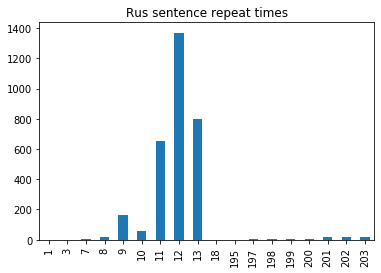

In [27]:
lens = [each[1] for each in seen_rus.items()]
unq = np.unique(lens)
qty = [lens.count(each) for each in unq]
pd.DataFrame(qty, index=unq).plot.bar(title = 'Rus sentence repeat times', legend=False);

#### Most duplicated sentences repeat 12 times, max up to 203 times

### Let's read that data while splitting the words. We'll count the words in each sentence. If the count in rus and trans is different, we'll record it as anomaly


Anomalies: 49


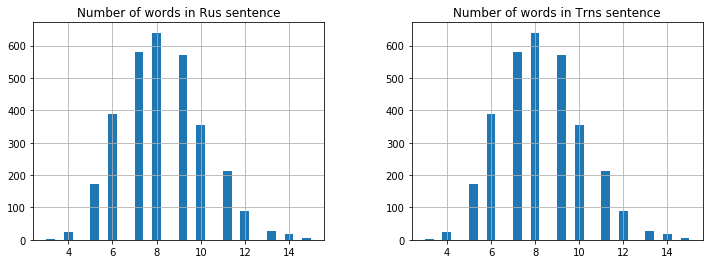

In [5]:
rus_l, trn_l, anomaly = [], [], []
seen = defaultdict(list)
chars = Counter()

for j,i in enumerate(rus_trn):
  rus = i[0].split()
  trn = re.split('#|_|%% %%',i[1])

  if i[0] not in seen:
    if abs(len(rus) - len(trn)) != 0: 
      anomaly.append(j)
    else:
      rus_l.append(len(rus))
      trn_l.append(len(trn))

    chars += Counter(i[0])  

  seen[i[0]].append(j)

print(f'Anomalies: {len(anomaly)}')
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
pd.DataFrame({'Number of words in Rus sentence':rus_l}).hist(ax=ax1, bins = 30);
pd.DataFrame({'Number of words in Trns sentence':trn_l}).hist(ax=ax2, bins = 30);

#### So we have 49 anomalies out of 3131 samples

### Let's see if we need to clean the data. First let's take a look at rus corpus alphabet

Number of times "-" used: 159


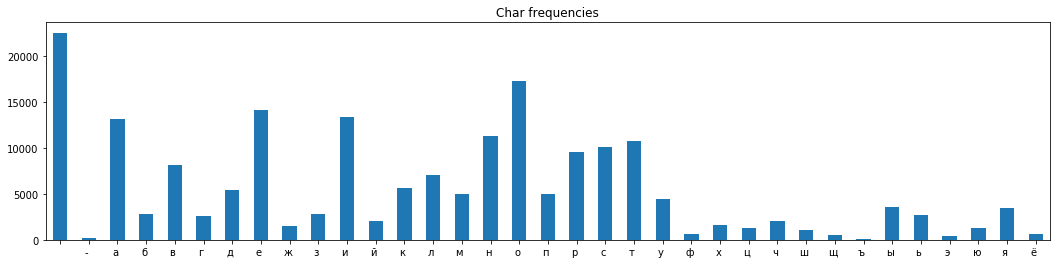

In [29]:
s = sorted(chars.items())
pd.DataFrame(s, index=(e[0]+' ' for e in s)).plot.bar(figsize=(18,4), rot=0, title = 'Char frequencies', legend=False)
print(f'Number of times "-" used: {chars["-"]}')

#### Looks good! We neither have punctuations nor capital letters. The only case to check is '-' letter which is used 159 times

In [4]:
seen = set()
seen_dash = set()
dash_words = []
for rus,trn in rus_trn:
  if rus not in seen:
    if '-' in rus:
      ru_words = rus.split()
      for each in ru_words:
        if '-' in each:
          if each not in seen_dash:
            seen_dash.add(each)
            dash_words.append(each)
  else:
    seen.add(rus)
  
print(dash_words)

['анти-обледенитель', 'иридо-диагностика', 'дом-красавец', 'из-за', 'радио-сигналом', 'ноль-три', 'ноль-два', 'мало-обеспеченные', 'шкаф-купе', 'тех-осмотр', 'пресс-службе', 'авто-сервис', 'чуть-чуть', 'аудио-', 'какие-либо', 'де-факто', 'стерео-', 'царь-колокол', 'царь-пушка', 'гео-магнитного', 'электро-катастрофы', 'фигуристы-новобранцы', 'что-то', 'какое-либо', 'веб-операторы', 'воздушно-десантной', 'военно-морских', 'ветераны-афганцы', 'одного-единственного', 'природно-климатические', 'одном-двух', 'санкт-петербурге', 'стран-участниц', 'пять-шесть', 'по-своему', 'матч-реванш', 'словаря-справочника', 'штаб-квартире', 'чем-то', 'чего-то', 'экс-губернатора', 'российско-американский', 'северо-восточных', 'красно-белую', 'какой-нибудь', 'бело-жёлтый', 'карту-схему', 'юго-западный', 'радио-охранное', 'по-прежнему', 'каким-то', 'кино-картины', 'авто-трюки', 'пресс-конференции', 'генерал-прокурором', 'нью-йорке', 'медиа-группы', 'нью-йоркской', 'какие-то', 'санкт-петербурга', 'санкт-петерб

#### Okey, words with dash look fine, we'll consider dash as a normal letter

### So in order to implement autocoder for transcript we'd need to keep special symbools in transcript such as "\_" and "%% %%". So let's create a dictionary of sentences rus <-> trans. So let's recreate the dictionary so "\_" and "%% %%" are marked with '#' and remove begin and end markers. Plus to that let's get rid of duplicates.


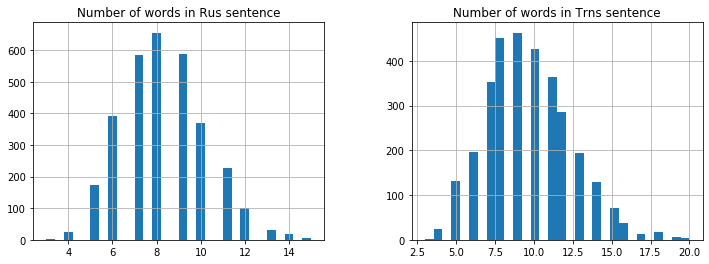

In [6]:
seen_rus = set()
seen_trn = set()

res, trn_l, rus_l = [], [], []

for rus, trn in rus_trn:

  if rus not in seen_rus or trn not in seen_trn:
      seen_rus.add(rus)
      seen_trn.add(trn)

      trn = trn.replace('%% %%', '#%% %%#').replace('_', '#_#')[2:-2]
      res.append((rus, trn))

      rus_l.append( len(rus.split()))
      trn_l.append( len(trn.split('#')))
      # if len(trn.split('#')) > 17:
      #   print(rus)
      #   print(trn)

rus_trn_new = array(res)
trn_length = max(trn_l)
rus_length = max(rus_l)
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
pd.DataFrame({'Number of words in Rus sentence':rus_l}).hist(ax=ax1, bins = 30);
pd.DataFrame({'Number of words in Trns sentence':trn_l}).hist(ax=ax2, bins = 30);

In [0]:
# trn = re.split(r'#|(_|%% %%)',rus_trn[0][1][2:-2])
# trn = list(filter(None, trn))
# '#'.join(trn)

### Text to Sequence Conversion

In [0]:
def tokenization(lines, split=' '):
  tokenizer = Tokenizer(filters='', split=split)
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [8]:
rus_tokenizer = tokenization(rus_trn_new[:, 0])
rus_vocab_size = len(rus_tokenizer.word_index) + 1
trn_tokenizer = tokenization(rus_trn_new[:, 1], split='#')
trn_vocab_size = len(trn_tokenizer.word_index) + 1
print('Rus Vocabulary Size: %d' % rus_vocab_size)
print('Trns Vocabulary Size: %d' % trn_vocab_size)

Rus Vocabulary Size: 12176
Trns Vocabulary Size: 13720


In [0]:
def encode_sequences(tokenizer, length, lines):
  seq = tokenizer.texts_to_sequences(lines)
  seq = pad_sequences(sequences=seq, maxlen=length, padding='post')
  return seq

In [22]:
import string

# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

# split a text into sentences
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t')[:2] for i in sents]
      return sents

data = read_text(gpath / 'My Drive/Samsung' / 'deu.txt')
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

deu_eng = deu_eng[:50000,:]

# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ['run', 'lauf'],
       ...,
       ['he has no specific aim', 'er hat kein bestimmtes ziel'],
       ['he has only four pesos', 'er hat nur vier pesos'],
       ['he has stopped smoking', 'er hörte mit dem rauchen auf']],
      dtype='<U537')

In [0]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 15
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')
model.summary()

# train model
history = model.fit(trainX, trainY.reshape(*trainY.shape, 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[], 
                    verbose=1)

English Vocabulary Size: 6345
Deutch Vocabulary Size: 10501
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 15, 512)           5376512   
_________________________________________________________________
lstm_15 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
repeat_vector_8 (RepeatVecto (None, 8, 512)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 8, 512)            2099200   
_________________________________________________________________
dense_8 (Dense)              (None, 8, 6345)           3254985   
Total params: 12,829,897
Trainable params: 12,829,897
Non-trainable params: 0
_________________________________________________________________
Train on 32000 samples, validate on 8000 samples

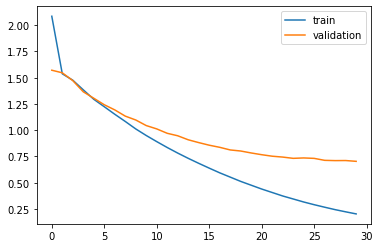

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [44]:
preds = model.predict_classes(testX[:100])
preds

preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

pred_df = pd.DataFrame({'actual' : test[:100,0], 'predicted' : preds_text})
# print 15 rows randomly
pred_df.sample(15)

,actual,predicted
40,how do i get one,how do i get one
32,hey where are you,hey where you are
36,tom has lost control,tom lost control
18,we gave it to the man,we made it a
76,tom killed a man,tom took a bath
11,tom moaned,tom is
8,tom will help us,tom will help us
0,tom won first prize,tom won the race
22,please be careful,please be careful
29,tom looks annoyed,tom looks angry


### Model Building


In [36]:
rus_trn_new.shape

(3172, 2)

In [0]:
train, test = train_test_split(rus_trn_new, test_size=0.2, random_state = RS)

# prepare training data
trainX = encode_sequences(rus_tokenizer, rus_length, train[:, 0])
trainY = encode_sequences(trn_tokenizer, trn_length, train[:, 1])

# prepare validation data
testX = encode_sequences(rus_tokenizer, rus_length, test[:, 0])
testY = encode_sequences(trn_tokenizer, trn_length, test[:, 1])

In [38]:
trainX.shape, trainY.shape

((2537, 15), (2537, 20))

In [39]:
testX.shape, testY.shape

((635, 15), (635, 20))

In [40]:
# build NMT model
def define_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
  model = Sequential()
  model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
  model.add(LSTM(units))
  model.add(RepeatVector(out_timesteps))
  model.add(LSTM(units, return_sequences=True))
  model.add(Dense(out_vocab, activation='softmax'))
  return model

model = define_model(rus_vocab_size, trn_vocab_size, rus_length, trn_length, 512)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 15, 512)           6234112   
_________________________________________________________________
lstm_7 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 20, 512)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 20, 512)           2099200   
_________________________________________________________________
dense_4 (Dense)              (None, 20, 13720)         7038360   
Total params: 17,470,872
Trainable params: 17,470,872
Non-trainable params: 0
_________________________________________________________________







Train on 2854 samples, validate on 318 samples
Epoch 1/30





2854/2854 [==============================] - 6s 2ms/step - loss: 7.5867 - val_loss: 5.5542
Epoch 2/30
2854/2854 [==============================] - 3s 1ms/step - loss: 5.4437 - val_loss: 5.8619
Epoch 3/30
2854/2854 [==============================] - 3s 1ms/step - loss: 5.2205 - val_loss: 5.6840
Epoch 4/30
2854/2854 [==============================] - 3s 1ms/step - loss: 4.9954 - val_loss: 5.6226
Epoch 5/30
2854/2854 [==============================] - 3s 1ms/step - loss: 4.7611 - val_loss: 5.5809
Epoch 6/30
2854/2854 [==============================] - 3s 1ms/step - loss: 4.6758 - val_loss: 5.5746
Epoch 7/30
2854/2854 [==============================] - 3s 1ms/step - loss: 4.6730 - val_loss: 5.5877
Epoch 8/30
2854/2854 [==============================] - 3s 1ms/step - loss: 4.6464 - val_loss: 5.5790
Epoch 9/30
2854/2854 [==============================] - 3s 1ms/step - loss: 4.6326 - val_loss: 5.5751
Epoch 10/30
2854/2854 [==

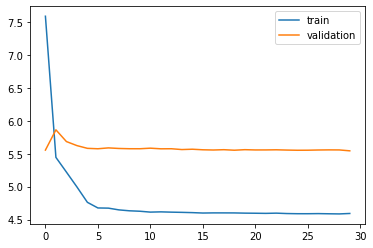

In [16]:
# optimizer = optimizers.RMSprop(lr=0.001)
optimizer=optimizers.Adam(lr=0.005)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')

momitor = 'val_loss'
mode = 'min'
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor=momitor, verbose=1, save_best_only=True, mode=mode)
early_stop = EarlyStopping( patience=25, monitor=momitor, mode=mode)

# train model
history = model.fit(trainX, trainY.reshape(*trainY.shape, 1),
                    validation_data=(testX, testY.reshape(*testY.shape, 1)),
                    epochs=30, batch_size=512, callbacks=[early_stop], 
                    verbose=1)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [17]:
# model = load_model('model.h5')
preds = model.predict_classes(testX)
preds

array([[3, 0, 0, ..., 0, 0, 0],
       [3, 0, 0, ..., 0, 0, 0],
       [3, 0, 0, ..., 0, 0, 0],
       ...,
       [3, 0, 0, ..., 0, 0, 0],
       [3, 0, 0, ..., 0, 0, 0],
       [3, 0, 0, ..., 0, 0, 0]])

In [18]:
testY

array([[7727, 7728, 7729, ...,    0,    0,    0],
       [   3,    1, 3518, ...,    0,    0,    0],
       [   5,    1,  314, ...,    0,    0,    0],
       ...,
       [ 234, 8209,  435, ...,    0,    0,    0],
       [ 101,   19,    1, ...,    0,    0,    0],
       [1511, 3298,  111, ...,    0,    0,    0]], dtype=int32)

In [29]:
def get_word(n, tokenizer):
  for word, index in tokenizer.word_index.items():
      if index == n:
          return word
  return None
  
t = []
for e in trainX[0]:
  s = get_word(e, rus_tokenizer)
  if s: t.append(s)
print( ' '.join(t) )

t = []
for e in trainY[0]:
  s = get_word(e, trn_tokenizer)
  if s: t.append(s)
print( '#'.join(t) )

ещё и фирмы клинтон
 n' 'ix' # f # a t # m' 'i1 r a 


In [18]:
preds

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [19]:
preds_text = []
for i in preds:
  print(i)
  temp = []
  for j in range(len(i)):
    t = get_word(i[j], trn_tokenizer)
    if j > 0:
      if (t == get_word(i[j-1], trn_tokenizer)) or (t == None):
        temp.append('')
      else:
        temp.append(t)
    else:
      if(t == None):
            temp.append('')
      else:
              temp.append(t) 

  preds_text.append('#'.join(temp))

pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})
pred_df.sample(15)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

KeyboardInterrupt: ignored